In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, dimension, num_layers, activation):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(dimension, dimension))
            self.layers.append(activation)

    def forward(self, x):
        residual = x
        for layer in self.layers:
            x = layer(x)
        return x + residual
        
class Autoencoder(nn.Module):
    def __init__(self, dimension, num_blocks, num_layers, activation):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, dimension),
            *[ResidualBlock(dimension, num_layers, activation) for _ in range(num_blocks)],
            nn.Linear(dimension, 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, dimension),
            *[ResidualBlock(dimension, num_layers, activation) for _ in range(num_blocks)],
            nn.Linear(dimension, 2)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [4]:
def generate_random_points(grid_size):
    spacing = 1 / (grid_size - 1) * 2
    
    # Generate evenly spaced grid points
    x = np.linspace(-1 + spacing / 2, 1 - spacing / 2, grid_size)
    y = np.linspace(-1 + spacing / 2, 1 - spacing / 2, grid_size)
    grid_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

    # Generate perturbations
    # perturbations = np.random.uniform(-spacing/2, spacing/2, size=(grid_size**2, 2))
    perturbations = np.zeros(shape=(grid_size**2, 2))
    
    # Add perturbations to the grid points
    perturbed_points = grid_points + perturbations
    perturbed_points_tensor = torch.from_numpy(perturbed_points).float()   
    return perturbed_points_tensor

In [117]:
# Training parameters
def train_autoencoder(model, iterations, grid_size, lr, momentum, schedule='exp', device='cpu'):
    if schedule == 'exp':
        gamma = 1 - 1.1e-3
        epochs = iterations
    elif schedule == 'cos':   
        end_lr = lr / 10
        decrement = (lr - end_lr) / (cycles - 1)
        decay = 1
        T_0 = 100
        T_mult = 2
        
        # calculate the total number of epochs to reach the end of the last cycle
        epochs = int(T_0 * (1 - T_mult ** (cycles)) / (1 - T_mult)) if T_mult != 1 else T_0 * cycles
    else:
        epochs = iterations
    
    lr_list = []
    loss_list = []
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.9))

    if schedule == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=1e-8)
    elif schedule == 'exp':
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    elif schedule == 'lin':
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0, epochs)

    for epoch in range(epochs):
        train_data = generate_random_points(grid_size).to(device)
        reconstructed_data = model(train_data)
        loss = criterion(reconstructed_data, train_data)

        if schedule is not None:
            lr_list.append(scheduler.get_last_lr()[0])
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if schedule == 'cos' and (scheduler.T_cur + 1) == scheduler.T_i:
            scheduler.base_lrs = [lr - decrement for lr in scheduler.base_lrs]
            scheduler.base_lrs = [lr*decay for lr in scheduler.base_lrs]
        if schedule is not None:
            scheduler.step()

        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.5f}")
        

    return model, lr_list, loss_list


In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

activations = {
    'ReLU': nn.ReLU()
    #'GELU': nn.GELU(),
    #'Sigmoid': nn.Sigmoid()
}

dim, blocks, layers = 256, 4, 4

models = {}
loss_lists = {}

for activation_name, activation_fn in activations.items():
    model = Autoencoder(dim, blocks, layers, activation_fn)
    # good lin lr: 0.001, epochs: 3000 | LOSS: 0.00621
    # good exp lr: 0.001, gamma: 1 - 1.1e-3, epochs: 6000 | loss: 0.00503
    # good cos lr: 0.001, T0: 100, T_mult: 2, end_lr: lr / 10, cycles: 8 (25500 epochs) | LOSS: 0.00185
    cycles, grid_size, lr, momentum = 3000, 32, 0.01, 0.0
    print(f"Training with {activation_name} activation")
    model, lr_list, loss_list = train_autoencoder(model, cycles, grid_size, lr, momentum, 'exp', device)
    models[activation_name] = model
    loss_lists[activation_name] = loss_list

cuda
Training with Sigmoid activation
Epoch [300/3000], Loss: 0.11445
Epoch [600/3000], Loss: 0.02932
Epoch [900/3000], Loss: 0.02562
Epoch [1200/3000], Loss: 0.02208
Epoch [1500/3000], Loss: 0.01755
Epoch [1800/3000], Loss: 0.01662
Epoch [2100/3000], Loss: 0.01576
Epoch [2400/3000], Loss: 0.01404
Epoch [2700/3000], Loss: 0.01269
Epoch [3000/3000], Loss: 0.01171


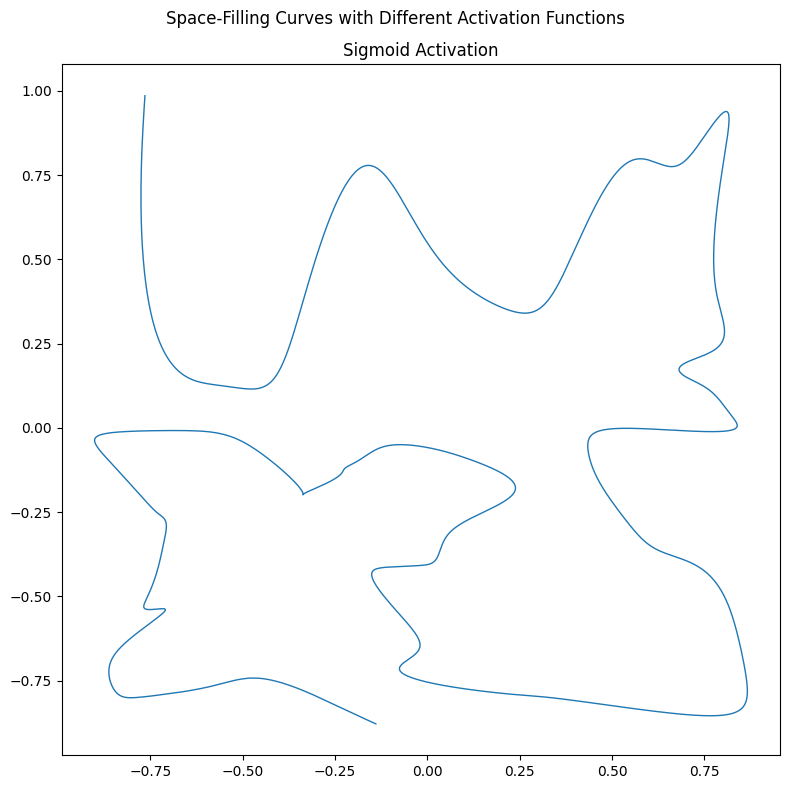

In [119]:
fig, axs = plt.subplots(1, len(activations), figsize=(8, 8))
if len(activations) == 1:
    axs = [axs]
    
fig.suptitle("Space-Filling Curves with Different Activation Functions")

def get_curve_points(model):
    grid = generate_random_points(32).cuda()
    
    with torch.no_grad():
        z = model.encoder(grid)
        min_val = z.min().item()
        max_val = z.max().item()
        num_points = int(1e5)
        z = torch.linspace(min_val, max_val, num_points).reshape(-1, 1).cuda()
        curve_points = model.decoder(z).cpu()
        
    return curve_points

for i, (activation_name, activation_fn) in enumerate(activations.items()):
    model = models[activation_name]
    curve_points = get_curve_points(model)

    #curve_points = generate_random_points(16)
    # Plot the space-filling curve
    axs[i].plot(curve_points[:, 0], curve_points[:, 1], linewidth=1, markersize=1)
    #axs[i].set_xlim(-1, 1)
    #axs[i].set_ylim(-1, 1)
    axs[i].set_title(f"{activation_name} Activation")

plt.tight_layout()
plt.show()

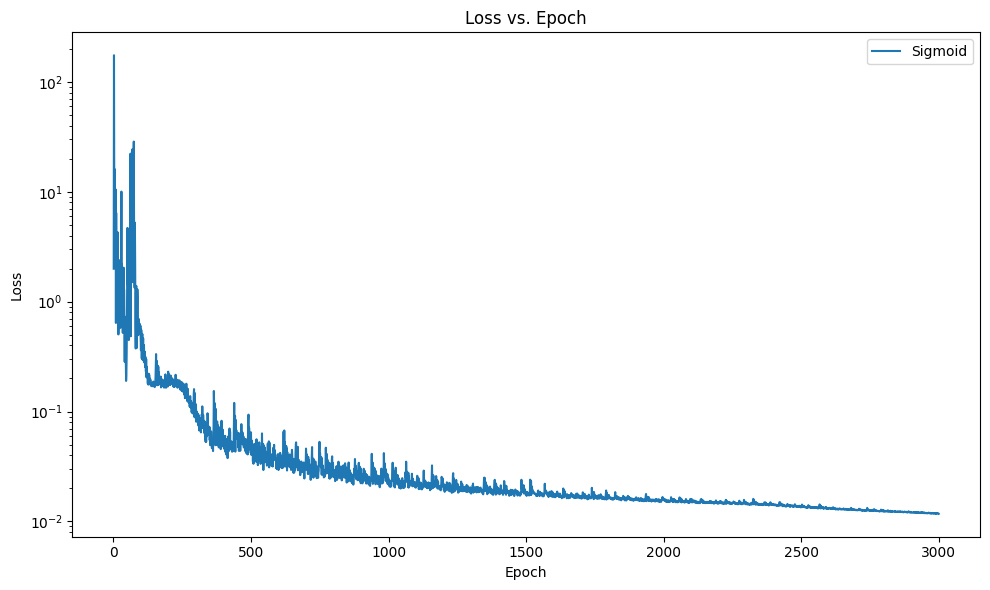

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale('log')
for activation_name, loss_list in loss_lists.items():
    ax.plot(range(1, len(loss_list) + 1), loss_list, label=activation_name)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epoch")
ax.legend()

plt.tight_layout()
plt.show()

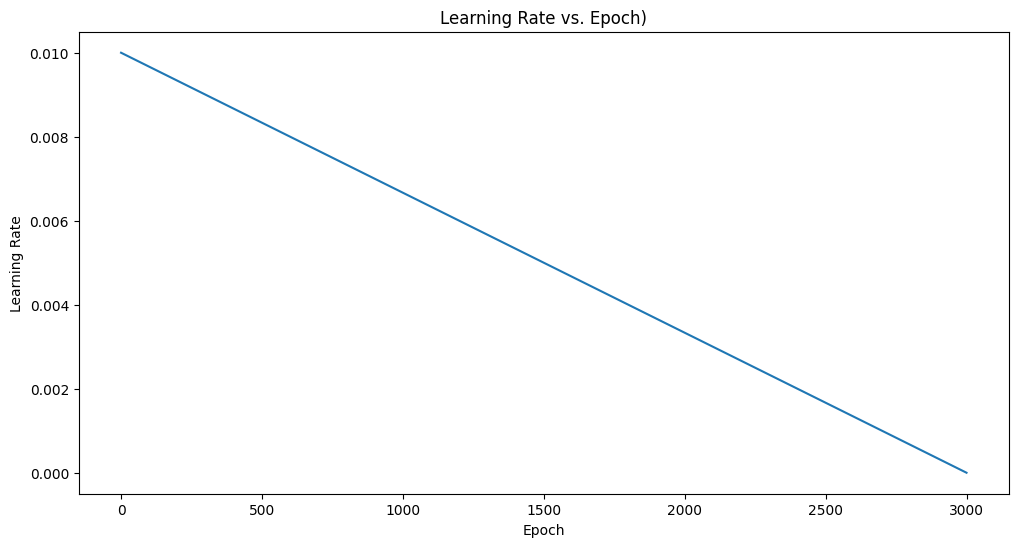

In [116]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(0, len(lr_list)), lr_list)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title(f"Learning Rate vs. Epoch)")
plt.show()